In [1]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import torch
import torchvision
import tqdm

# Convenience imports
from random import choice 
from numpy import array, dot, random
import sklearn.datasets
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm_notebook as tqdm
import copy
import itertools
import pandas as pd

np.random.seed(1)
%matplotlib inline

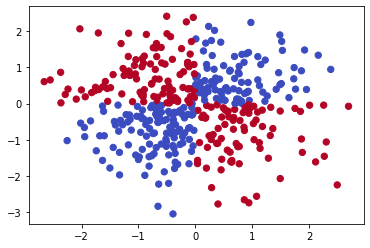

In [2]:
## Generate a dataset and plot it

## Moons Dataset ##
# X, y = sklearn.datasets.make_moons(200, noise=0.20)

## Circles dataset ##
# X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)

## XOR with noise ##
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(400, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int) 

## AND with noise ##
# xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
#                      np.linspace(-3, 3, 50))
# rng = np.random.RandomState(0)
# X = rng.randn(400, 2)
# y = np.logical_and(X[:, 0] > 0, X[:, 1] > 0).astype(int) 


# Plot the dataset
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.coolwarm)

In [3]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [5]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [6]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [7]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 0.757321
Loss after iteration 1000: 0.430950
Loss after iteration 2000: 0.430943
Loss after iteration 3000: 0.430942
Loss after iteration 4000: 0.430941
Loss after iteration 5000: 0.430941
Loss after iteration 6000: 0.430940
Loss after iteration 7000: 0.430940
Loss after iteration 8000: 0.430940
Loss after iteration 9000: 0.430940
Loss after iteration 10000: 0.430939
Loss after iteration 11000: 0.430939
Loss after iteration 12000: 0.430939
Loss after iteration 13000: 0.430939
Loss after iteration 14000: 0.430939
Loss after iteration 15000: 0.430939
Loss after iteration 16000: 0.430939
Loss after iteration 17000: 0.430939
Loss after iteration 18000: 0.430939
Loss after iteration 19000: 0.430939


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

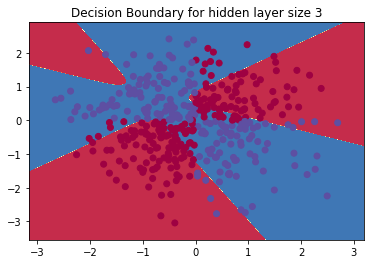

In [8]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")